# Classic ANN

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler

RM_dataFrame = pd.read_csv("RM_9.csv") ## read in the file into DataFrame (pandas object)
QA_RM = RM_dataFrame[RM_dataFrame["Q"].notna() & RM_dataFrame["σci (MPa) (intact rock)"].notna() & RM_dataFrame["Em (GPa)"].notna()] ##only keep rows with known Q, classification, Em
# QA_RM["Q_processed"] = np.log(QA_RM["Q"]) #Q is an exponential scale, so we take log of it
# QA_RM["Q_processed"] = (QA_RM["Q_processed"] - QA_RM["Q_processed"].min())/(QA_RM["Q_processed"].max() - QA_RM["Q_processed"].min()) #scale log(Q) between min and max
# QA_RM["Em_processed"] = (QA_RM["Em (GPa)"] - QA_RM["Em (GPa)"].min())/(QA_RM["Em (GPa)"].max() - QA_RM["Em (GPa)"].min()) # scale Em simply
QA_RM["σci (MPa) (intact rock)"] = QA_RM["σci (MPa) (intact rock)"].astype(float)
# QA_RM["σci (MPa) (intact rock)"] = (QA_RM["σci (MPa) (intact rock)"] - QA_RM["σci (MPa) (intact rock)"].min())/(QA_RM["σci (MPa) (intact rock)"].max() - QA_RM["σci (MPa) (intact rock)"].min()) # scale Em simply
# print(QA_RM.loc[:,["Q_processed","Em_processed"]])

X_all = QA_RM.loc[:, ("Q", "Em (GPa)", "σci (MPa) (intact rock)")].to_numpy() #convert inputs to numpy
scaler = MaxAbsScaler() ##scale columns to 0-1
scaler.fit(X_all) ##create scaler object
X_scaled = scaler.transform(X_all) #apply to all data
X = X_scaled[:,:2] #split into X, Y
Y = X_scaled[:,2]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2) #train test split

In [ ]:
print(X_scaled)

In [ ]:
import tensorflow as tf
model = tf.keras.models.Sequential([
  # tf.keras.layers.Dense(128, activation='tanh'),
  # tf.keras.layers.Dense(128, activation='tanh'),
  # tf.keras.layers.Dense(64, activation='tanh'),
    # tf.keras.layers.Dense(64, activation='sigmoid'),
  # tf.keras.layers.Dense(64, activation='relu'),
  # tf.keras.layers.Dense(1, activation='tanh')
    tf.keras.layers.Dense(1, activation='linear')
])
# predictions = model(X).numpy()
# print(predictions.shape)
loss_fn = tf.keras.losses.MeanAbsoluteError() ##define loss function to optimise
# loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=1e-4) ##define optimiser
# opt = tf.keras.optimizers.SGD(learning_rate=1e-3) ##define optimiser
model.compile(optimizer=opt,
              loss=loss_fn,
              metrics=['MeanAbsoluteError','MeanSquaredError']) ##put it together
model.build(X_train.shape) #build model
model.summary() #show number of parameters

In [ ]:
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100) ##train model, use X_test, Y_test for validation

In [ ]:
loss = model.history.history['loss'] ##get train loss per epoch
val_loss = model.history.history['val_loss'] ## val loss
import matplotlib.pyplot as plt
plt.plot(loss,label='train loss') ##plotting
plt.plot(val_loss,label='val loss')
plt.legend()

In [ ]:
Y_pred = model.predict(X_test) ## run model on test data
X_pred_all_scaled = np.hstack((X_test,Y_pred)) ##stack to scale back to engineering units
X_test_all_scaled = np.hstack((X_test,Y_test.reshape(-1,1)))
X_test_all = scaler.inverse_transform(X_test_all_scaled) ##scale test data
X_pred_all = scaler.inverse_transform(X_pred_all_scaled) ##scale predicted outputs
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(20, 5)) ## make 3 outputs
axs[0].scatter(X_test_all[:,0],X_test_all[:,2],label='true') ##plot all combinations
axs[0].scatter(X_pred_all[:,0],X_pred_all[:,2],label='pred')
axs[0].set_xlabel("Q")
axs[0].set_ylabel("σci (MPa) (intact rock)")
axs[0].legend()
axs[1].scatter(X_test_all[:,1],X_test_all[:,2],label='true')
axs[1].scatter(X_test_all[:,1],X_pred_all[:,2],label='pred')
axs[1].set_xlabel("Em (GPa)")
axs[2].scatter(X_test_all[:,2],X_pred_all[:,2]) ##plot true vs predicted
axs[2].plot([0, 250],[0,250])
axs[2].set_xlabel("True σci (MPa) (intact rock)")
axs[2].set_ylabel("Pred σci (MPa) (intact rock)")

# Convolutional NN

In [ ]:
## tutorial from https://www.analyticsvidhya.com/blog/2020/02/learn-image-classification-cnn-convolutional-neural-networks-3-datasets/
from keras.datasets import cifar10 ##classic image dataset, https://www.cs.toronto.edu/~kriz/cifar.html,
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data() #load dataset
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

In [ ]:
import matplotlib.pyplot as plt
check_i = 10
plt.imshow(X_train[check_i,:,:,:])
print(Y_train[check_i])

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
import tensorflow as tf
# from keras.utils import np_utils

take_n = 50000
X_train_small = X_train[:take_n,:,:,:].astype('float32')/255 #normalise color intensity to 0-1, only take first 1000 for speed
Y_train_small = Y_train[:take_n]
X_test = X_test.astype('float32')/255
n_classes = 10
print("Shape before one-hot encoding: ", Y_train_small.shape)
print(Y_train_small[:10])
Y_train_small = (tf.keras.utils.to_categorical(Y_train_small, n_classes))
Y_test = (tf.keras.utils.to_categorical(Y_test, n_classes))
# Y_train_small = np_utils.to_categorical(Y_train_small, n_classes)
# Y_test = np_utils.to_categorical(Y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train_small.shape)
print(Y_train_small[:10,:])

In [ ]:
import tensorflow as tf
# building a linear stack of layers with the sequential model
model = Sequential()

# convolutional layer
model.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(32, 32, 3)))

# convolutional layer
model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# model.add(AveragePooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

model.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# flatten output of conv
model.add(Flatten())

# hidden layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
# output layer
model.add(Dense(10, activation='softmax'))

# compiling the sequential model
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
model.summary()

In [ ]:
# training the model for 10 epochs
model.fit(X_train_small, Y_train_small, batch_size=32, epochs=10, validation_data=(X_test, Y_test))

In [ ]:
loss = model.history.history['loss'] ##get train loss per epoch
val_loss = model.history.history['val_loss'] ## val loss
import matplotlib.pyplot as plt
plt.plot(loss,label='train loss') ##plotting
plt.plot(val_loss,label='val loss')
plt.legend()

In [ ]:
Y_pred = model.predict(X_test) #run test data

In [ ]:
check_i = 81 ##let's plot some images, see what is predicted
plt.imshow(X_test[check_i,:,:,:])
print(Y_test[check_i,:])
print(Y_pred[check_i,:])

In [ ]:
from sklearn.metrics import average_precision_score ##check precision recall accuracy scores
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
import numpy as np
print("precision = {}".format(average_precision_score(Y_test, Y_pred)))
print("accuracy = {}".format(accuracy_score(np.argmax(Y_test,axis=1), np.argmax(Y_pred,axis=1)))) ##need to use argmax to turn one-hot-encoding back into single label e.g. 0,1,2,3,4,5....,9
print("recall = {}".format(recall_score(np.argmax(Y_test,axis=1), np.argmax(Y_pred,axis=1),average='macro')))

# Recurrent NN

In [ ]:
import pandas as pd ##adapted from https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816
import numpy as np

AAPL_df = pd.read_csv("AAPL.csv") ##apple
AAPL_df = AAPL_df.iloc[::-1]
TSLA_df = pd.read_csv("TSLA.csv") ##tesla
TSLA_df = TSLA_df.iloc[::-1]
KO_df = pd.read_csv("KO.csv") ##coca cola
KO_df = KO_df.iloc[::-1]
print(KO_df)

            Date Close/Last    Volume    Open     High      Low
1258  11/13/2017     $46.72   7640384   $46.6  $46.815   $46.54
1257  11/14/2017     $47.43  17198680  $46.71   $47.48   $46.62
1256  11/15/2017     $46.81  12409620  $47.32   $47.46   $46.78
1255  11/16/2017     $46.55  12506160  $46.95   $46.98   $46.51
1254  11/17/2017     $45.71  19715450  $46.34   $46.38   $45.25
...          ...        ...       ...     ...      ...      ...
4     11/07/2022     $59.49   8849704  $59.26   $59.77   $59.24
3     11/08/2022      $59.6  10081650  $59.75   $59.79   $58.94
2     11/09/2022     $58.77  10115160  $59.59   $59.64  $58.751
1     11/10/2022     $60.88  16804850  $60.25   $61.04   $59.68
0     11/11/2022     $61.32  18972080  $61.37   $61.45   $60.21

[1259 rows x 6 columns]


<ipython-input-10-766ad2b8fd84>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  axs[0].scatter(AAPL_df["Date"],AAPL_df["Close/Last"].str.replace('$', '').astype("float"))
<ipython-input-10-766ad2b8fd84>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  axs[1].scatter(TSLA_df["Date"],TSLA_df["Close/Last"].str.replace('$', '').astype("float"))
<ipython-input-10-766ad2b8fd84>:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  axs[2].scatter(KO_df["Date"],KO_df["Close/Last"].str.replace('$', '').astype("float"))


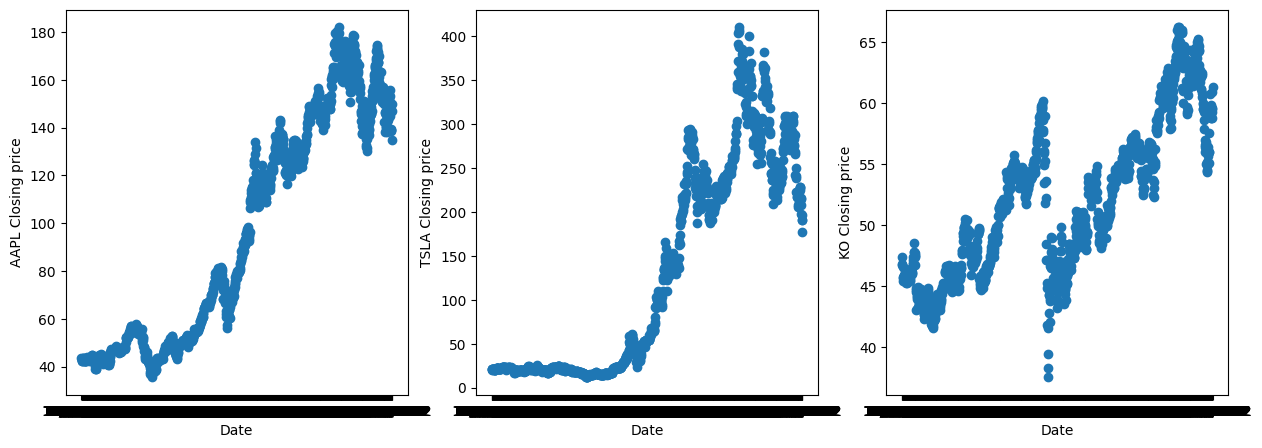

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(15,5)) #lets try plot these
axs[0].scatter(AAPL_df["Date"],AAPL_df["Close/Last"].str.replace('$', '').astype("float"))
axs[0].set_xlabel("Date")
axs[0].set_ylabel("AAPL Closing price")
axs[1].scatter(TSLA_df["Date"],TSLA_df["Close/Last"].str.replace('$', '').astype("float"))
axs[1].set_xlabel("Date")
axs[1].set_ylabel("TSLA Closing price")
axs[2].scatter(KO_df["Date"],KO_df["Close/Last"].str.replace('$', '').astype("float"))
axs[2].set_xlabel("Date")
axs[2].set_ylabel("KO Closing price")
plt.show()

In [ ]:
X = np.zeros((len(KO_df),3)) ##make array to hold data
X[:,0] = AAPL_df["Close/Last"].str.replace('$', '').astype("float") ##remove dollart sign, convert to float
X[:,1] = KO_df["Close/Last"].str.replace('$', '').astype("float")
X[:,2] = TSLA_df["Close/Last"].str.replace('$', '').astype("float")
print(X)

[[ 43.4925  46.72    21.0267]
 [ 42.835   47.43    20.58  ]
 [ 42.27    46.81    20.7533]
 ...
 [134.87    58.77   177.59  ]
 [146.87    60.88   190.72  ]
 [149.7     61.32   195.97  ]]


<ipython-input-11-3b84897388c9>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X[:,0] = AAPL_df["Close/Last"].str.replace('$', '').astype("float") ##remove dollart sign, convert to float
<ipython-input-11-3b84897388c9>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X[:,1] = KO_df["Close/Last"].str.replace('$', '').astype("float")
<ipython-input-11-3b84897388c9>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X[:,2] = TSLA_df["Close/Last"].str.replace('$', '').astype("float")


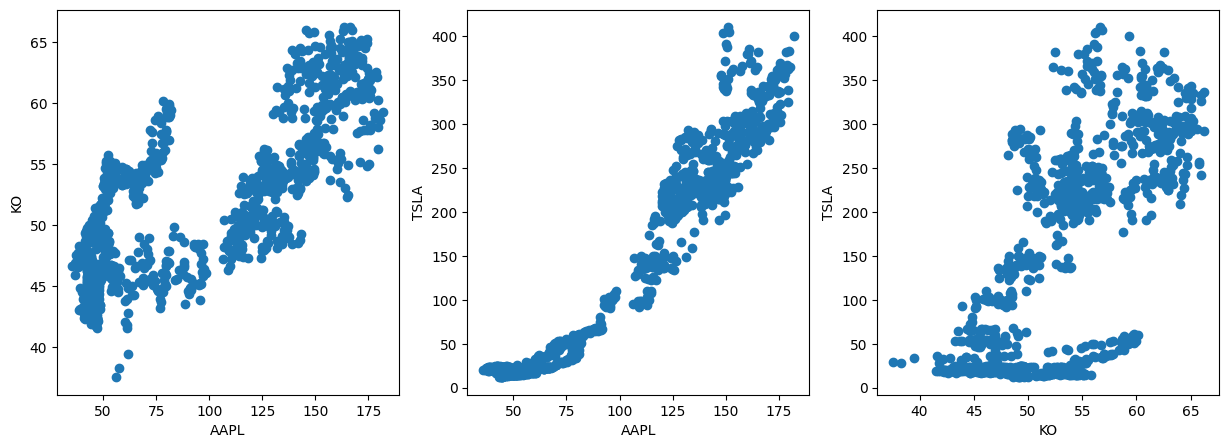

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(15,5)) #lets try plot these
axs[0].scatter(X[:,0],X[:,1])
axs[0].set_xlabel("AAPL")
axs[0].set_ylabel("KO")
axs[1].scatter(X[:,0],X[:,2])
axs[1].set_xlabel("AAPL")
axs[1].set_ylabel("TSLA")
axs[2].scatter(X[:,1],X[:,2])
axs[2].set_xlabel("KO")
axs[2].set_ylabel("TSLA")
plt.show()

In [ ]:
from sklearn.preprocessing import MaxAbsScaler #scale again
scaler = MaxAbsScaler() ##scale columns to 0-1
scaler.fit(X) ##create scaler object
X_scaled = scaler.transform(X) #apply to all data
train_period = np.floor(0.8*len(X)).astype('int') ###since it's time series, use first 4 of 5 years as train
X_train = X_scaled[:train_period,:] #test-train split, be careful to formulate as predict next day of stock
X_test = X_scaled[train_period:-1,:]
Y_train = X_scaled[1:train_period+1,1]
Y_test = X_scaled[train_period+1:,1]

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator
look_back = 16 ## use last 32 days to predict next day

train_generator = TimeseriesGenerator(X_train, Y_train, length=look_back) #chop into 32 day chunks
test_generator = TimeseriesGenerator(X_test, Y_test, length=look_back)


#*LSTM version*#


In [ ]:
## LSTM version
import tensorflow as tf
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(32,return_sequences=True)) ##put in LSTM
model.add(tf.keras.layers.LSTM(64,return_sequences=False))
model.add(tf.keras.layers.Dense(64,activation='tanh')) #dense layers
# model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(1,activation='tanh')) #single predicted value
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss='mse')

In [ ]:
model.fit(train_generator, validation_data=test_generator, epochs=25)
model.summary() #show number of parameters

Epoch 1/25
8/8 [==============================] - 7s 111ms/step - loss: 0.2021 - val_loss: 0.0017
Epoch 2/25
8/8 [==============================] - 0s 11ms/step - loss: 0.0179 - val_loss: 0.0056
Epoch 3/25
8/8 [==============================] - 0s 12ms/step - loss: 0.0373 - val_loss: 0.0045
Epoch 4/25
8/8 [==============================] - 0s 11ms/step - loss: 0.0161 - val_loss: 0.0015
Epoch 5/25
8/8 [==============================] - 0s 12ms/step - loss: 0.0056 - val_loss: 0.0079
Epoch 6/25
8/8 [==============================] - 0s 12ms/step - loss: 0.0050 - val_loss: 0.0041
Epoch 7/25
8/8 [==============================] - 0s 11ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 8/25
8/8 [==============================] - 0s 12ms/step - loss: 0.0030 - val_loss: 0.0048
Epoch 9/25
8/8 [==============================] - 0s 11ms/step - loss: 0.0026 - val_loss: 0.0079
Epoch 10/25
8/8 [==============================] - 0s 12ms/step - loss: 0.0020 - val_loss: 0.0063
Epoch 11/25
8/8 [===========

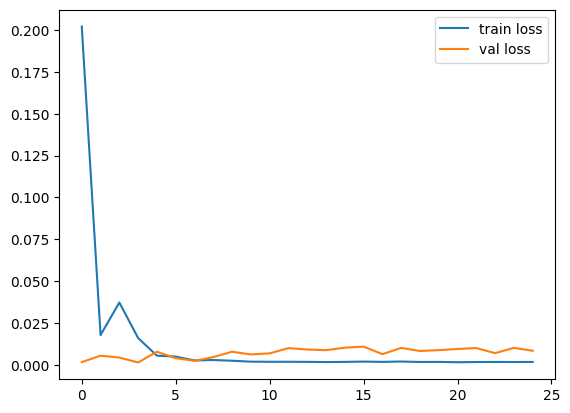

In [ ]:
loss = model.history.history['loss'] ##get train loss per epoch
val_loss = model.history.history['val_loss'] ## val loss
import matplotlib.pyplot as plt
plt.plot(loss,label='train loss') ##plotting
plt.plot(val_loss,label='val loss')
plt.legend()

In [ ]:
Y_pred = model.predict(test_generator) #run test data

2/2 [==============================] - 1s 8ms/step


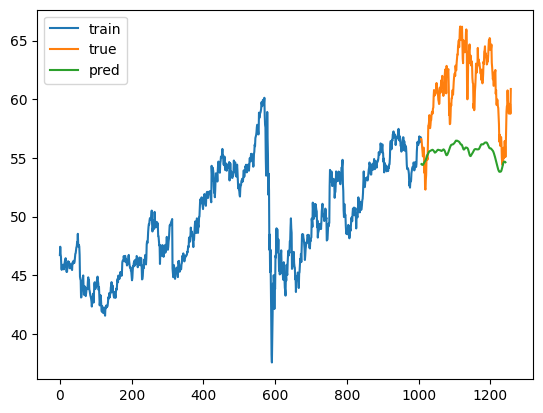

In [ ]:
Y_pred_flat = Y_pred.reshape((-1))##flatten inputs
Y_pred_inv = np.zeros((len(Y_pred_flat),3))
Y_pred_inv[:,1] = Y_pred_flat
Y_pred_inv = scaler.inverse_transform(Y_pred_inv)
X_train_inv = scaler.inverse_transform(X_train)
X_test_inv = scaler.inverse_transform(X_test)

# plt.plot(np.arange(0,train_period),X_train[:,2],label='train')
# plt.plot(np.arange(train_period,train_period+len(X_test)),X_test[:,2],label='true')
# plt.plot(np.arange(train_period+1,train_period+len(Y_pred_flat)+1),Y_pred_flat,label='pred')
plt.plot(np.arange(0,train_period),X_train_inv[:,1],label='train')
plt.plot(np.arange(train_period,train_period+len(X_test)),X_test_inv[:,1],label='true')
plt.plot(np.arange(train_period+1,train_period+len(Y_pred_flat)+1),Y_pred_inv[:,1],label='pred')
plt.legend()
# plt.ylim(0, 0.1)

(251, 3)
(235,)


Text(0, 0.5, 'Predicted stock price - true stock price')

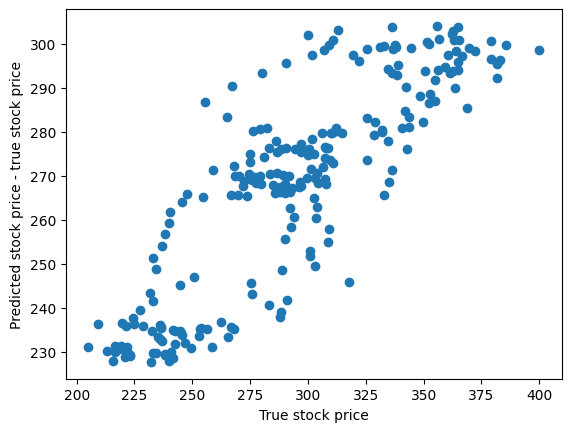

In [ ]:
print(X_test.shape)
print(Y_pred_flat.shape)
plt.scatter(X_test_inv[:-look_back,2],Y_pred_inv[:,2])
plt.xlabel("True stock price")
plt.ylabel("Predicted stock price - true stock price")

# Transformer version

In [ ]:
!pip install tf-models-official ##install tensorflow_models to environment

In [ ]:
import tensorflow_models as tfm
# model = tf.keras.models.Sequential()
# model.add(tfm.nlp.models.TransformerEncoder( ##define encoder
#     num_layers=1,
#     num_attention_heads=1,
#     intermediate_size=1,
#     activation='relu',
#     dropout_rate=0.0,
#     attention_dropout_rate=0.0,
#     use_bias=False,
#     norm_first=True,
#     norm_epsilon=1e-06,
#     intermediate_dropout=0.0
# ))
# model.add(tfm.nlp.models.TransformerDecoder( ##define decoder
#     num_layers=1,
#     num_attention_heads=1,
#     intermediate_size=1,
#     activation='relu',
#     dropout_rate=0.0,
#     attention_dropout_rate=0.0,
#     use_bias=False,
#     norm_first=True,
#     norm_epsilon=1e-06,
#     intermediate_dropout=0.0
# ))
look_back_transformer = 32 ## use last 32 days to predict next day
inputs = tf.keras.Input(shape=(None, None, look_back_transformer))
attn_output = tf.keras.layers.MultiHeadAttention(num_heads=1, key_dim=1)(inputs,inputs)
x = tf.keras.layers.add([inputs, attn_output])
outputs = tf.keras.layers.LayerNormalization()(x)

full_model = tf.keras.Model(inputs, outputs)
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
full_model.compile(optimizer=opt, loss='mse')

In [ ]:
stock_interest = 0 ## this transformer definition only uses 1D input, so we will only use 1 stock at a time
train_period = np.floor(0.8*len(X)).astype('int') ###since it's time series, use first 4 of 5 years as train
X_train_transformer = X_scaled[:train_period,stock_interest] #test-train split, be careful to formulate as predict next day of stock
X_test_transformer = X_scaled[train_period:-1,stock_interest]
Y_train_transformer = X_scaled[1:train_period+1,stock_interest]
Y_test_transformer = X_scaled[train_period+1:,stock_interest]



from keras.preprocessing.sequence import TimeseriesGenerator
train_generator_transformer = TimeseriesGenerator(X_train_transformer, Y_train_transformer, length=look_back_transformer,batch_size=2) #chop into 32 day chunks
test_generator_transformer = TimeseriesGenerator(X_test, Y_test_transformer, length=look_back_transformer,batch_size=2)

In [ ]:
# model.fit(train_generator_transformer, validation_data=test_generator_transformer, epochs=25)
full_model.fit(train_generator_transformer, validation_data=test_generator_transformer, epochs=25)
full_model.summary() #show number of parameters